In [11]:
%pip install tensorboard --quiet
%pip install seaborn --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [12]:
import sys
sys.path.append('/workspace/cropClassification')
sys.path.append('/workspace/cropClassification/model')
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import torch
import pandas as pd
from torch.utils.data import DataLoader

from unet import originalUNet, encodeDropUNet
from compiler import ModelCompiler
from dataloader import RoadsideCropImageDataset
from loss import BalancedCrossEntropyLoss

In [13]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use GPU with CUDA
    print("Using CUDA")
elif torch.backends.mps.is_available():
    device = torch.device("mps")  # Use Apple M1/M2 GPU with MPS (Metal Performance Shaders)
    print("Using MPS")
else:
    device = torch.device("cpu")  # Fall back to CPU
    print("Using CPU")

Using CUDA


### Configuration

In [14]:
config = {
    "model": {
        "type": "originalUNet",  # Example model type, replace with your actual model class name
        "params": {
            "in_channels": 9,  # Since we are using 9-channel input images
            "out_channels": 3   # Number of output classes for segmentation
        }
    },
    "training": {
        "epochs": 50,
        "batch_size": 64,
        "learning_rate": 0.1,
        "optimizer": {
            "type": "Adam",
            "params": {
                "lr": 0.1
            }
        },
        "scheduler": {
            "type": "StepLR",
            "params": {
                "step_size": 10,
                "gamma": 0.5
            }
        },
        "criterion": BalancedCrossEntropyLoss(),  # or you can use your custom loss like BalancedCrossEntropyLoss
        "resume" : False,
        "resume_epoch" : None,
    },
    "validation": {
        "epochs": 50,
        "batch_size": 16
    },
    "dataset": {
        "train_csv": "/workspace/data/data/masked_data_csiss/training/train_chipping_csv.csv",  # Path to the training DataFrame (includes npy file paths)
        "val_csv": "/workspace/data/data/masked_data_csiss/validation/validation_chipping_csv.csv", # Path to the validation DataFrame (includes npy file paths)
        "train_root_path": "/workspace/data/data/masked_data_csiss/training",
        "val_root_path": "/workspace/data/data/masked_data_csiss/validation",
        "image_column": "img_chip_path",             # Column containing the image paths (npy files)
        "mask_column": "lbl_chip_path",              # Column containing the mask paths
        "train_mean": [93.8785585, 111.81092494, 76.94555781, 113.58929434, 206.93557473, 28.98472963,
                       46.53684269, 113.74437327, 116.23856585],  # Mean values for training set normalization
        "train_std": [53.24595916, 46.34658429, 45.91157286, 47.69937365, 82.32605363, 48.02506071,
                       22.46416468, 52.31732116, 47.89290138],   # Std values for training set normalization
        "val_mean": [88.62211239, 111.27628711, 75.19030815, 111.99622799, 223.21125121, 25.98495476, 
                     49.64829283, 115.91463906, 114.01573621],    # Mean values for validation set normalization
        "val_std": [53.97481266, 46.47043658, 45.64034871, 48.20284577, 59.89659002, 41.7467965,
                     20.82148233, 54.41768437, 47.68361442],     # Std values for validation set normalization
    },
    "evaluation": {
        "filename": "csiss_street_view_crop_classification.csv",  # Evaluation metrics to be used
        "class_mapping": {
            0: "Background",
            1: "Maize",
            2: "Soybean"
        }
    }
}

### Loading Datasets

In [15]:
train_df = pd.read_csv(config['dataset']['train_csv'])
val_df = pd.read_csv(config['dataset']['val_csv'])

In [16]:
train_dataset = RoadsideCropImageDataset(
    dataframe=train_df,
    root_dir=config['dataset']['train_root_path'],  # Root directory where images are stored
    usage='train',  # Indicates training dataset
    mean=config['dataset']['train_mean'],
    std=config['dataset']['train_std']
)

val_dataset = RoadsideCropImageDataset(
    dataframe=val_df,
    root_dir=config['dataset']['val_root_path'],  # Root directory where images are stored
    usage='val',  # Indicates validation dataset
    mean=config['dataset']['val_mean'],
    std=config['dataset']['val_std']
)

In [17]:
train_loader = DataLoader(train_dataset, batch_size=config['training']['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config['training']['batch_size'], shuffle=False)

### Construct Model and Training

##### Original UNet

In [8]:
model = originalUNet(n_channels=config['model']['params']['in_channels'],
                     n_classes=config['model']['params']['out_channels'])
model_comp = ModelCompiler(model=model,
                           params_init=None)

---------- GPU (CUDA) available ----------
Total number of trainable parameters: 13.4M
---------- originalUNet model compiled successfully ----------


In [9]:
model_comp.fit(
    trainDataset=train_loader,
    valDataset=val_loader,
    epochs=config['training']['epochs'],
    optimizer_name=config['training']['optimizer']['type'],
    lr_init=config['training']['learning_rate'],
    lr_policy='steplr',  # Use 'steplr' as specified in config
    criterion=config['training']['criterion'],
    log=True,  # Enable logging for TensorBoard
    return_loss=False,
    **config['training']['scheduler']['params'])

-------------------------- Start training --------------------------
----------------------- [1/50] -----------------------
Epoch Training Loss: 0.8302
Current Learning Rate: 0.010000
Validation Loss: 0.7824
Epoch 1 completed in 1919.44 seconds
----------------------- [2/50] -----------------------
Epoch Training Loss: 0.7419
Current Learning Rate: 0.010000
Validation Loss: 0.7813
Epoch 2 completed in 1895.20 seconds
----------------------- [3/50] -----------------------
Epoch Training Loss: 0.7151
Current Learning Rate: 0.010000
Validation Loss: 0.8700
Epoch 3 completed in 1914.79 seconds
----------------------- [4/50] -----------------------
Epoch Training Loss: 0.7272
Current Learning Rate: 0.010000
Validation Loss: 0.7868
Epoch 4 completed in 2031.74 seconds
----------------------- [5/50] -----------------------
Epoch Training Loss: 0.7249
Current Learning Rate: 0.010000
Validation Loss: 0.8327
Epoch 5 completed in 2092.24 seconds
----------------------- [6/50] --------------------

---------------- Start evaluation ----------------


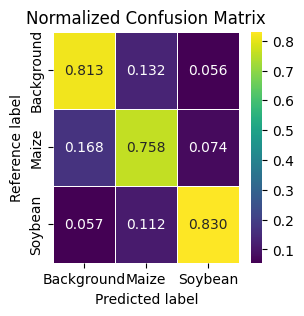

---------------- Evaluation finished in 341s ----------------


In [10]:
model_comp.accuracy_evaluation(eval_dataset=val_loader,
                               filename=config['evaluation']['filename'], 
                               num_classes=config['model']['params']['out_channels'], 
                               class_mapping=config['evaluation']['class_mapping'])

##### Encoder Dropout UNet

In [18]:
model = encodeDropUNet(n_channels=config['model']['params']['in_channels'],
                     n_classes=config['model']['params']['out_channels'],
                     drop_rate=0.3)
model_comp = ModelCompiler(model=model,
                           params_init=None)

---------- GPU (CUDA) available ----------
Total number of trainable parameters: 13.4M
---------- encodeDropUNet model compiled successfully ----------


In [19]:
model_comp.fit(
    trainDataset=train_loader,
    valDataset=val_loader,
    epochs=config['training']['epochs'],
    optimizer_name=config['training']['optimizer']['type'],
    lr_init=config['training']['learning_rate'],
    lr_policy='steplr',  # Use 'steplr' as specified in config
    criterion=config['training']['criterion'],
    log=True,  # Enable logging for TensorBoard
    return_loss=False,
    **config['training']['scheduler']['params'])

-------------------------- Start training --------------------------
----------------------- [1/50] -----------------------
Epoch Training Loss: 0.9558
Current Learning Rate: 0.100000
Validation Loss: 0.8886
Epoch 1 completed in 1869.37 seconds
----------------------- [2/50] -----------------------
Epoch Training Loss: 0.8669
Current Learning Rate: 0.100000
Validation Loss: 0.8362
Epoch 2 completed in 1858.04 seconds
----------------------- [3/50] -----------------------
Epoch Training Loss: 0.8664
Current Learning Rate: 0.100000
Validation Loss: 0.8324
Epoch 3 completed in 1768.18 seconds
----------------------- [4/50] -----------------------
Epoch Training Loss: 0.8747
Current Learning Rate: 0.100000
Validation Loss: 0.8373
Epoch 4 completed in 1706.91 seconds
----------------------- [5/50] -----------------------
Epoch Training Loss: 0.8662
Current Learning Rate: 0.100000
Validation Loss: 0.8012
Epoch 5 completed in 1708.13 seconds
----------------------- [6/50] --------------------

---------------- Start evaluation ----------------


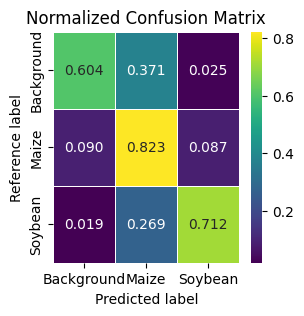

---------------- Evaluation finished in 346s ----------------


In [20]:
model_comp.accuracy_evaluation(eval_dataset=val_loader,
                               filename=config['evaluation']['filename'], 
                               num_classes=config['model']['params']['out_channels'], 
                               class_mapping=config['evaluation']['class_mapping'])